<a href="https://phelma-sicom-3pmpols6-cours-bayartpi-a42652bdaf1952804ff1824b4d.gricad-pages.univ-grenoble-alpes.fr" target="_blank">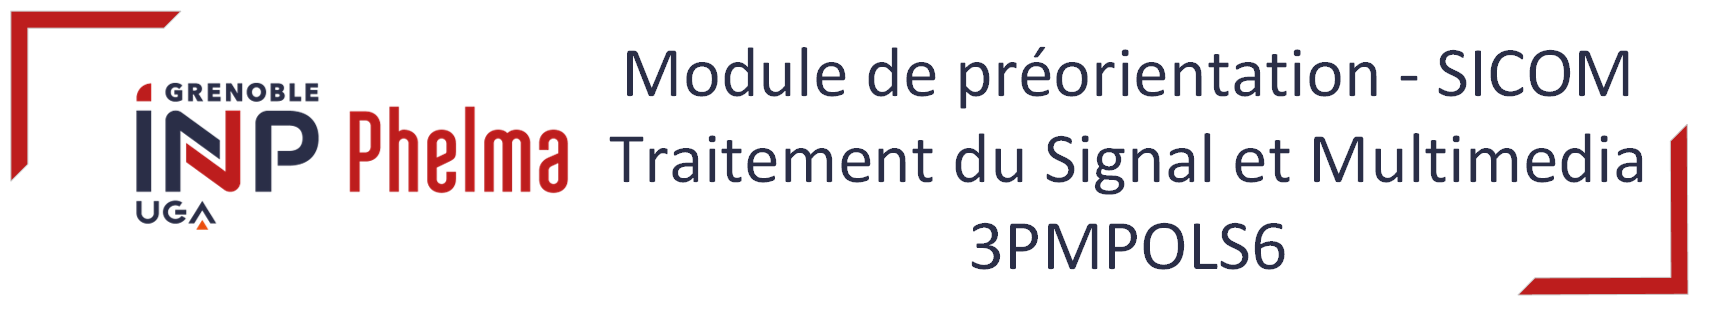</a>

# TD 2 - Partie 2

**Objectifs de ce TD :**

- 🖼️ Comprendre les **réseaux de neurones de convolution (CNN)**
- 🧠 Comprendre les différences de fonctionnement entre les réseaux de neurones **denses** et de **convolution**
___

## Préparation : mise en place de l'environnement de travail du TD

Cette **phase préparatoire** se déroule en deux temps :

1. **Importation des bibliothèques** Python nécessaires pour le TD

💻 *Exécuter le code de la cellule et vérifier qu'il n'y a pas d'erreurs. Un message de warning doit apparaître. A quoi correspond ce message ?*

In [1]:
## Importation des bibliothèques Python nécessaires au TD
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Markdown as md
import plotly.graph_objects as go

2023-12-05 11:38:47.105042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2. **Création des fonctions** pour générer les **images utilisées** pour le TD

💻 *Exécuter le code de la cellule*

In [2]:
def create_seven_segment_display(number=0, sigma=1, norm=True):
    image = np.zeros((28, 28)) # Image noir de fond
    # Position des segments sur l'image
    segments = {
        'a': [(max(0, round(random.gauss(2, sigma))), i) for i in range(7, 21)],
        'b': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(3, 13)],
        'c': [(i, min(27, round(random.gauss(22, sigma)))) for i in range(15, 25)],
        'd': [(min(27, round(random.gauss(25, sigma))), i) for i in range(7, 21)],
        'e': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(15, 25)],
        'f': [(i, max(0, round(random.gauss(5, sigma)))) for i in range(3, 13)],
        'g': [(max(0, min(27, round(random.gauss(13, sigma)))), i) for i in range(7, 21)],
    }
    # Liste des positions des segments pour les valeurs héxadécimales
    digits = [
        "abcdef", "bc", "abged", "abgcd", "fgbc",
        "afgcd", "afgcde", "fabc", "abcdefg", "abcdfg",
        "efabcg", "fedcg", "afed", "bcdeg", "afged",
        "afge",
    ]
    # Création du chiffre choisi dans le paramètre "number"
    for seg in [segments[dig] for dig in digits[number]]:
        for y, x in seg:
            if norm is True:
                image[y, x] = 1
            else:
                image[y, x] = 255
    return image

def create_dataset(nb_train=6000, nb_test=1000, val=(3, 15), sigma=1, all_nb=False, norm=True):
    X_train, y_train, X_test, y_test = [], [], [], []
    # Toutes les valeurs hexadicémales (suppression des deux valeurs par défaut)
    if all_nb is True:
        val = range(0, 10)
    for _ in range(nb_train):
        for digit in val:
            X_train.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_train.append(digit)
            else:
                y_train.append(0 if digit==val[0] else 1)
    for _ in range(nb_test):
        for digit in val:
            X_test.append(create_seven_segment_display(digit, sigma, norm=norm))
            if all_nb is True:
                y_test.append(digit)
            else:
                y_test.append(0 if digit==val[0] else 1)
    return (np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

def create_new_dataset(dataset, rand=True, zero=True):
    """
    Fonction pour générer des nouvelles données
    à partir du jeu de données MNIST, Fashion MNIST
    """
    if rand is None or zero is None:
        raise ValueError("Les paramètres rand et zero doivent être définis")
    new_size = (56, 56)
    positions = ["haut_gauche", "haut_droite", "bas_gauche", "bas_droite"]
    new_dataset = list()
    for image in dataset:
        if zero is True:
            new_image = np.zeros((56, 56))
        else:
            new_image = np.random.rand(56, 56)
        if rand is True:
            pos_x = random.randint(0, 56-28)
            pos_y = random.randint(0, 56-28)
            new_image[pos_x:pos_x+28, pos_y:pos_y+28] = image.reshape(28, 28)
        else:
            pos = random.choice(positions)
            if pos=="haut_gauche":
                new_image[0:28, 0:28] = image.reshape(28, 28)
            elif pos=="haut_droite":
                new_image[0:28, 28:] = image.reshape(28, 28)
            elif pos=="bas_gauche":
                new_image[28:, 0:28] = image.reshape(28, 28)
            elif pos=="bas_droite":
                new_image[28:, 28:] = image.reshape(28, 28)
        new_dataset.append(new_image.reshape(56, 56, 1))
    new_dataset = np.array(new_dataset)
    return new_dataset

3. **Création des fonctions** pour générer les **modèles de réseaux de neurones** pour le TD

💻 *Exécuter le code de la cellule*

In [3]:
def fcn(input_shape=(28, 28, 1), output=1, activation="sigmoid"):
    """
    Création du réseau de neurones complétement connecté
    """
    print("Réseau dense")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(name="Couche_entree"),
            layers.Dense(output, activation=activation, name="Couche_sortie"),
        ]
    )
    print(model.summary())
    return model

def cnn(input_shape=(56, 56, 1)):
    """
    Création du réseau de neurones de convolution
    """
    print("Réseau CNN")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(1, kernel_size=(28, 28), activation="relu", strides=(28, 28)),
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    print(model.summary())
    return model

def train_evaluate(model, x_train, y_train, x_test, y_test, loss="binary_crossentropy", epochs=10):
    """
    Entrainement et évaluation du modèle
    """
    model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    return score[1]

___

## Analyse et comparaison des poids des réseaux de convolution et complétement connectés

💻 *Exécuter le code et analyser les dimensions de l'image. A quoi correspondent les 3 dimensions de l'image ?*

In [4]:
num_classes = 10
(x_train, y_train, x_test, y_test) = create_dataset(sigma=0.3, all_nb=True, norm=True)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape[0], "Images d'entrainement")
print(x_test.shape[0], "Images de test")
print("Dimensions d'une image : ", x_train[0].shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 Images d'entrainement
10000 Images de test
Dimensions d'une image :  (28, 28, 1)


💻 *Exécuter le code et analyser l'image. L'étiquette est-elle cohérente avec l'image ?*

Etiquette :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


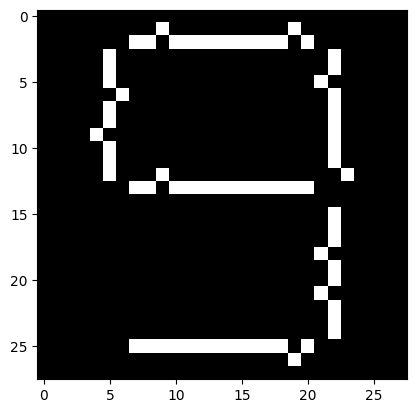

In [5]:
rnd_value = random.randint(0, 60000)
print("Etiquette : ", y_train[rnd_value])
plt.imshow(x_train[rnd_value], cmap='gray')
plt.show()

💻 *Exécuter le code et analyser l'image. Essayer différents combinaisons de paramètres `rand` et `zero`*


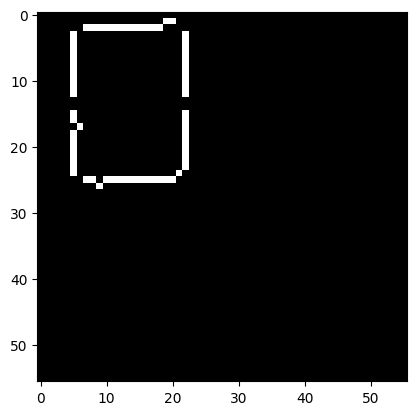

In [6]:
rnd_value = random.randint(0, 600)
new_x_train = create_new_dataset(x_train, rand=False, zero=True)
new_x_test = create_new_dataset(x_test, rand=False, zero=True)
plt.imshow(new_x_train[rnd_value], cmap='gray')
plt.show()

💻 *Exécuter le code et analyser le résultat de l'entrainement du réseau dense.*

In [7]:
model_fcn = fcn(input_shape=(56, 56, 1), output=10, activation="softmax")
result_fcn = train_evaluate(model_fcn, new_x_train, y_train, new_x_test, y_test, loss="categorical_crossentropy", epochs=10)

Réseau dense
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Couche_entree (Flatten)     (None, 3136)              0         
                                                                 
 Couche_sortie (Dense)       (None, 10)                31370     
                                                                 
Total params: 31370 (122.54 KB)
Trainable params: 31370 (122.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
422/422 [==============================] - 4s 7ms/step - loss: 2.2857 - accuracy: 0.4939 - val_loss: 2.2686 - val_accuracy: 0.9153
Epoch 2/10
422/422 [==============================] - 3s 7ms/step - loss: 2.2517 - accuracy: 0.9102 - val_loss: 2.2350 - val_accuracy: 0.9553
Epoch 3/10
422/422 [==============================] - 3s 6ms/step - loss: 2.2181 - accuracy: 0.9336 - val_loss: 

💻 *Exécuter le code et analyser les poids du modèle*

In [8]:
# Extraire les poids de la première couche dense
weights_fcn = model_fcn.layers[1].get_weights()[0]
weights_reshaped_fcn = weights_fcn.reshape(56, 56, -1)

# Fonction pour mettre à jour le graphique
def update_plot(neuron_index):

    print(f"Exemples de données d'entrainement pour le chiffre {neuron_index}")
    # Afficher 10 images
    fig, axs = plt.subplots(1, 10, figsize=(15, 15))
    count = 0
    for i in range(1000):
        if y_train[i].argmax()==neuron_index:
            axs[count].imshow(new_x_train[i], cmap='gray')
            axs[count].axis('off')
            count += 1
        if count==10:
            break
    plt.show()
    
    fig = go.Figure(data=[go.Surface(
        z=weights_reshaped_fcn[:, :, neuron_index],
    )])

    fig.update_layout(
        title=f'Poids du neurone {neuron_index} de la couche de sortie',
        scene_xaxis_autorange="reversed",
        scene=dict(zaxis=dict(range=[-1,1])),
        width=800,
        height=600,
    )
    
    fig.show()

    print(f'Représentation statique des poids du neurone {neuron_index} de la couche de sortie')
    plt.imshow(weights_reshaped_fcn[:, :, neuron_index], cmap='gray')
    plt.axis('off')
    plt.show()

# Création de la liste déroulante
neuron_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=9,
    step=1,
    description='Neurone:',
    continuous_update=False
)

# Interactivité
widgets.interactive(update_plot, neuron_index=neuron_selector)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Neurone:', max=9), Output()), _…

Pour **faciliter la compréhension** des poids des filtres de convolution, le réseau de neurones est entrainé pour **détecter un chiffre** parmi les 10 (de 0 à 9).

💻 *Exécuter le code pour créer le nouveau jeu de données. Analyser les nouveaux jeux de données créés.*

In [9]:
# Création du nouveau jeu de données
def create_indices(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    final_indice = []
    for i in indices:
        if y[i].argmax()==6:
            final_indice.append(i)
        else:
            if random.random()>0.9:
                final_indice.append(i)
    return final_indice
train_indices = create_indices(new_x_train, y_train)
test_indices = create_indices(new_x_test, y_test)
# Mise à jour des données
x_train_binary = new_x_train[train_indices]
y_train_binary = (y_train[train_indices].argmax(axis=1)==6).astype(int)
x_test_binary = new_x_test[test_indices]
y_test_binary = (y_test[test_indices].argmax(axis=1)==6).astype(int)

💻 *Exécuter le code et analyser le résultat de l'entrainement du réseau de convolution.*

In [10]:
model = cnn(input_shape=(56, 56, 1))
test_acc_fcn = train_evaluate(model, x_train_binary, y_train_binary, x_test_binary, y_test_binary, loss="binary_crossentropy", epochs=50)

Réseau CNN
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 2, 1)           785       
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 790 (3.09 KB)
Trainable params: 790 (3.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
80/80 [==============================] - 2s 13ms/step - loss: 0.6924 - accuracy: 0.5282 - val_loss: 0.6925 - val_accuracy: 0.5158
Epoch 2/50
80/80 [==============================] - 1s 8ms/step - loss: 0.6914 - accuracy: 0.5298 - val_loss: 0.6919 - val_accuracy

💻 *Exécuter le code et analyser les poids du modèle*

Représentation 3D des poids du noyau de convolution


Représentation statique des poids du noyau de convolution


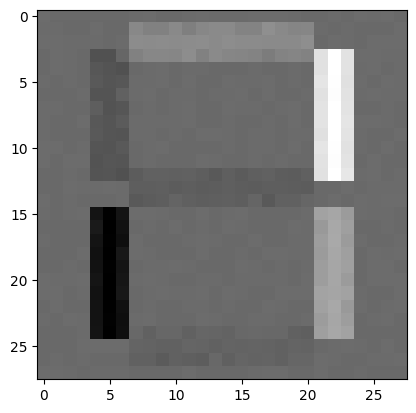

In [11]:
print('Représentation 3D des poids du noyau de convolution')
weights = model.layers[0].get_weights()[0]
weights_reshaped = weights.reshape(28, 28, -1)    
fig = go.Figure(data=[go.Surface(
    z=weights_reshaped[:, :, 0],
)])
fig.update_layout(
    scene_xaxis_autorange="reversed",
    width=800,
    height=600,
)
fig.show()
print('Représentation statique des poids du noyau de convolution')
weights = model.layers[0].get_weights()[0]
weights_reshaped = weights.reshape(28, 28, -1)
plt.imshow(weights_reshaped, cmap="gray")
plt.show()

## Analyse de l'apprentissage des réseaux de convolution et complétement connectés sur des images de complexités croissantes

Pour **complexifier** le travail d'apprentissage des réseaux de neurones, nous allons **créer 4 nouveaux jeu de données** à partir du jeu **Fashion MNIST**. Au total, nous allons travailler avec 5 jeu de données :
- **JEU DE DONNEES N°1** : Le jeu de données Fashion MNIST
- **JEU DE DONNEES N°2** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond noir**
- **JEU DE DONNEES N°3** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond bruité**
- **JEU DE DONNEES N°4** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond noir**
- **JEU DE DONNEES N°5** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond bruité**

Les différents jeux de données sont créés grâce aux deux paramètres `rand` et `zero` de la fonction `create_new_dataset` :

- `rand` : positionne l'image aléatoirement si la valeur vaut `True` et à un des 4 coins de l'image si la valeur vaut `False`
- `zero` : rempli le fond de l'image en noir si la valeur vaut `True` et avec du bruit si la valeur vaut `False`

💻 *Exécuter le code et tester les 4 configurations en changeant les paramètres de la fonction `create_new_dataset`* 

60000 Images d'entrainement
10000 Images de test
Dimensions d'une image :  (28, 28, 1)
Etiquette :  Bottine


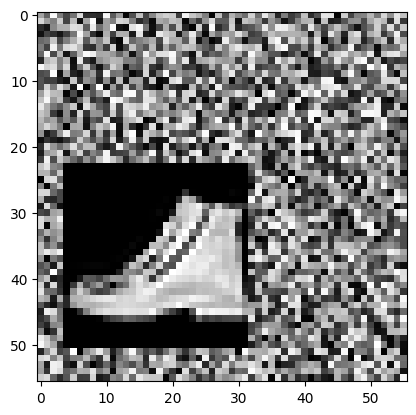

In [12]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape[0], "Images d'entrainement")
print(x_test.shape[0], "Images de test")
print("Dimensions d'une image : ", x_train[0].shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
new_x_train = create_new_dataset(x_train, rand=True, zero=False)
names = np.array([
    "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
    "Sandale", "Chemise", "Basket", "Sac", "Bottine",
])
rnd_value = random.randint(0, 60000)
print("Etiquette : ", names[y_train[rnd_value].argmax()])
plt.imshow(new_x_train[rnd_value], cmap='gray')
plt.show()

💻 *Exécuter le code pour la création des réseaux de neurones*

In [13]:
def fcn(nb_neurons=180, input_shape=(28, 28, 1), num_classes=10):
    """
    Création du réseau de neurones complétement connecté
    """
    print("Réseau dense")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Flatten(),
            layers.Dense(nb_neurons, activation="relu"),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    print(model.summary())
    return model

def cnn(nb_neurons_1=100, nb_neurons_2=70, input_shape=(28, 28, 1), num_classes=10):
    """
    Création du réseau de neurones de convolution
    """
    print("Réseau CNN")
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(nb_neurons_1, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(nb_neurons_2, kernel_size=(3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dropout(.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    print(model.summary())
    return model

def train_evaluate(model, x_train, y_train, x_test, y_test):
    """
    Entrainement et évaluation du modèle
    """
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=128, epochs=3, validation_split=0.1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    return score[1]

L'objectif de cette partie est de **comparer les performances** des deux modèles (modèle dense et de convolution) sur les **5 jeux de données**.

Les temps d'entrainement des réseaux de convolution étant assez long sur CPU, vous n'allez entrainer des modèles que sur **DEUX** jeux de données :
- **JEU DE DONNEES N°1** : Le jeu de données Fashion MNIST (pour tous les groupes)

Et **UN** jeu de données parmi les 4 suivants :
- **JEU DE DONNEES N°2** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond noir**
- **JEU DE DONNEES N°3** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond bruité**
- **JEU DE DONNEES N°4** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond noir**
- **JEU DE DONNEES N°5** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond bruité**

🎲 Il y a de nombreux processus aléatoires dans l'entrainement du modèle (initialisation des poids, création des batch de données...), il est donc normal de **ne pas trouver exactement** les mêmes résultats que les autres étudiants pour un même modèle et un même jeu de données. Néanmoins, les ordres de grandeurs doivent être cohérents.

💻 *Au fur et à mesure de l'entrainement des différents modèles, ajouter les résultats des métriques d'**accuracy** dans les variables. Le code suivant génére un tableau formaté en markdown* 

In [14]:
test_acc_fcn_1 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DENSE SUR LE JEU DE DONNES 1
test_acc_cnn_1 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 1
temps_fcn_1 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DENSE SUR LE JEU DE DONNES 1
temps_cnn_1 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 1
test_acc_fcn_2 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DENSE SUR LE JEU DE DONNES 2
test_acc_cnn_2 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 2
temps_fcn_2 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DENSE SUR LE JEU DE DONNES 2
temps_cnn_2 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 2
test_acc_fcn_3 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DENSE SUR LE JEU DE DONNES 3
test_acc_cnn_3 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 3
temps_fcn_3 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DENSE SUR LE JEU DE DONNES 3
temps_cnn_3 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 3
test_acc_fcn_4 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DENSE SUR LE JEU DE DONNES 4
test_acc_cnn_4 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 4
temps_fcn_4 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DENSE SUR LE JEU DE DONNES 4
temps_cnn_4 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 4
test_acc_fcn_5 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DENSE SUR LE JEU DE DONNES 5
test_acc_cnn_5 = 0 # A REMPLIR AVEC L'ACCURACY DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 5
temps_fcn_5 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DENSE SUR LE JEU DE DONNES 5
temps_cnn_5 = 0 # A REMPLIR AVEC LE TEMPS D'ENTRAINEMENT SUR LES 3 EPOQUES DU MODELE DE CONVOLUTION SUR LE JEU DE DONNES 5
# Affichage du tableau
md(f"""
| Nom du jeu de données  | Accuracy réseau dense | Accuracy réseau de convolution | Temps entrainement réseau dense (en s) | Temps entrainement réseau de convolution (en s) |
| -------- | ------- | ------- | ------- | ------- |
| JEU DE DONNEES N°1 : Fashion MNIST  | {round(test_acc_fcn_1, 3)} | {round(test_acc_cnn_1, 3)} | {round(temps_fcn_1, 3)} | {round(temps_cnn_1, 3)} |
| JEU DE DONNEES N°2 : 4 coins - fond noir  | {round(test_acc_fcn_2, 3)} | {round(test_acc_cnn_2, 3)} | {round(temps_fcn_2, 3)} | {round(temps_cnn_2, 3)} |
| JEU DE DONNEES N°3 : 4 coins - fond aleatoire  | {round(test_acc_fcn_3, 3)} | {round(test_acc_cnn_3, 3)} | {round(temps_fcn_3, 3)} | {round(temps_cnn_3, 3)} |
| JEU DE DONNEES N°4 : position aléatoire - fond noir  | {round(test_acc_fcn_4, 3)} | {round(test_acc_cnn_4, 3)} | {round(temps_fcn_4, 3)} | {round(temps_cnn_4, 3)} |
| JEU DE DONNEES N°5 : position aléatoire - fond aleatoire  | {round(test_acc_fcn_5, 3)} | {round(test_acc_cnn_5, 3)} | {round(temps_fcn_5, 3)} | {round(temps_cnn_5, 3)} |
""")


| Nom du jeu de données  | Accuracy réseau dense | Accuracy réseau de convolution | Temps entrainement réseau dense (en s) | Temps entrainement réseau de convolution (en s) |
| -------- | ------- | ------- | ------- | ------- |
| JEU DE DONNEES N°1 : Fashion MNIST  | 0 | 0 | 0 | 0 |
| JEU DE DONNEES N°2 : 4 coins - fond noir  | 0 | 0 | 0 | 0 |
| JEU DE DONNEES N°3 : 4 coins - fond aleatoire  | 0 | 0 | 0 | 0 |
| JEU DE DONNEES N°4 : position aléatoire - fond noir  | 0 | 0 | 0 | 0 |
| JEU DE DONNEES N°5 : position aléatoire - fond aleatoire  | 0 | 0 | 0 | 0 |


💻 Une fois le tableau complétement rempli, analyser les résultats

### Entrainement et évaluation des 2 modèles avec le jeu d'images Fashion MNIST

L'objectif de cette partie est de **comparer** les performances en terme d'**accuracy** sur le jeu de données **Fashion MNIST** des deux modèles de réseaux de neurones : un **réseau dense** et un **réseau de convolution**.

💻 *Exécuter le code et reporter les résultats de l'accuracy sur le jeu de données de test dans le tableau de synthèse des résultats pour le modèle dense*

In [15]:
# Entrainement du modèle dense sur le jeu de données Fashion MNIST
model = fcn()
test_acc_fcn_1 = train_evaluate(model, x_train, y_train, x_test, y_test)

Réseau dense
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 180)               141300    
                                                                 
 dense_2 (Dense)             (None, 10)                1810      
                                                                 
Total params: 143110 (559.02 KB)
Trainable params: 143110 (559.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
422/422 [==============================] - 4s 8ms/step - loss: 0.5579 - accuracy: 0.8074 - val_loss: 0.4420 - val_accuracy: 0.8448
Epoch 2/3
422/422 [==============================] - 2s 5ms/step - loss: 0.4110 - accuracy: 0.8547 - val_loss: 0.4145 -

💻 *Exécuter le code et reporter les résultats de l'accuracy sur le jeu de données de test dans le tableau de synthèse des résultats pour le modèle de convolution*

In [16]:
# Entrainement du modèle de convolution sur le jeu de données Fashion MNIST
model = cnn()
test_acc_cnn_1 = train_evaluate(model, x_train, y_train, x_test, y_test)

Réseau CNN
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 100)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 70)        63070     
                                                                 
 flatten_2 (Flatten)         (None, 8470)              0         
                                                                 
 dropout (Dropout)           (None, 8470)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                84710     
                                           

💻 *Comparer les résultats des deux modèles (dense et de convolution) en termes d'accuracy mais aussi de temps d'entrainement*

### Entrainement et évaluation des 2 modèles avec le jeu d'images Fashion MNIST modifié

L'objectif de cette partie est de **comparer** les performances en terme d'**accuracy** sur le jeu de données **Fashion MNIST modifié** des deux modèles de réseaux de neurones : un **réseau dense** et un **réseau de convolution**. Il faut choisir un des 4 jeux de données suivant :

- **JEU DE DONNEES N°2** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond noir**
- **JEU DE DONNEES N°3** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine positionné à un des **4 coins de l'image** sur **fond bruité**
- **JEU DE DONNEES N°4** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond noir**
- **JEU DE DONNEES N°5** : Le jeu de données Fashion MNIST recréé avec des données **4 fois plus grande** en dimension **56x56x1** avec l'image d'origine **positionné aléatoirement** sur **fond bruité**

💻 *Modifier les paramètres `rand` et `zero` de la fonction `create_new_dataset` pour générer le jeu de données choisi (⚠️ les valeurs des paramètres doivent être les mêmes pour le jeu d'entrainement et de test)*

In [17]:
# Création des nouveaux jeux de données
new_x_train = create_new_dataset(x_train, rand=True, zero=False) # Paramètres rand et zero à définir
new_x_test = create_new_dataset(x_test, rand=True, zero=False) # Paramètres rand et zero à définir

💻 *Exécuter le code et vérifier que le bon jeu de données a été créé*

Etiquette :  Pull


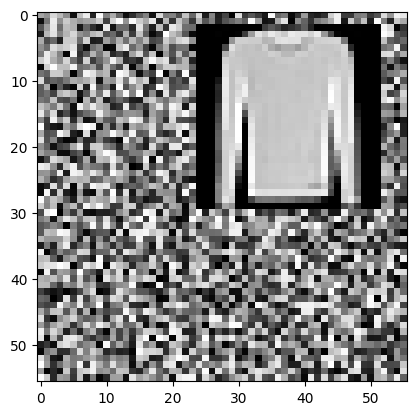

In [18]:
names = np.array([
    "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
    "Sandale", "Chemise", "Basket", "Sac", "Bottine",
])
rnd_value = random.randint(0, 60000)
print("Etiquette : ", names[y_train[rnd_value].argmax()])
plt.imshow(new_x_train[rnd_value], cmap='gray')
plt.show()

💻 *Exécuter le code et reporter les résultats de l'accuracy sur le jeu de données de test dans le tableau de synthèse des résultats pour le modèle dense*

In [19]:
# Entrainement du modèle dense sur le jeu de données Fashion MNIST
model = fcn(nb_neurons=45, input_shape=(56, 56, 1))
test_acc_fcn_2 = train_evaluate(model, new_x_train, y_train, new_x_test, y_test)

Réseau dense
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 45)                141165    
                                                                 
 dense_5 (Dense)             (None, 10)                460       
                                                                 
Total params: 141625 (553.22 KB)
Trainable params: 141625 (553.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
422/422 [==============================] - 3s 6ms/step - loss: 2.0675 - accuracy: 0.2113 - val_loss: 1.8846 - val_accuracy: 0.2620
Epoch 2/3
422/422 [==============================] - 2s 6ms/step - loss: 1.7740 - accuracy: 0.3246 - val_loss: 1.7322 -

💻 *Exécuter le code et reporter les résultats de l'accuracy sur le jeu de données de test dans le tableau de synthèse des résultats pour le modèle de convolution*

In [ ]:
# Entrainement du modèle de convolution sur le jeu de données Fashion MNIST modifié
model = cnn(nb_neurons_1=50, nb_neurons_2=21, input_shape=(56, 56, 1))
test_acc_cnn_2 = train_evaluate(model, new_x_train, y_train, new_x_test, y_test)

Réseau CNN
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 54, 54, 50)        500       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 50)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 21)        9471      
                                                                 
 flatten_4 (Flatten)         (None, 13125)             0         
                                                                 
 dropout_1 (Dropout)         (None, 13125)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                131260    
                                           

💻 *Comparer les résultats des deux modèles (dense et de convolution) en termes d'accuracy mais aussi de temps d'entrainement*

<a href="https://phelma.grenoble-inp.fr" target="_blank">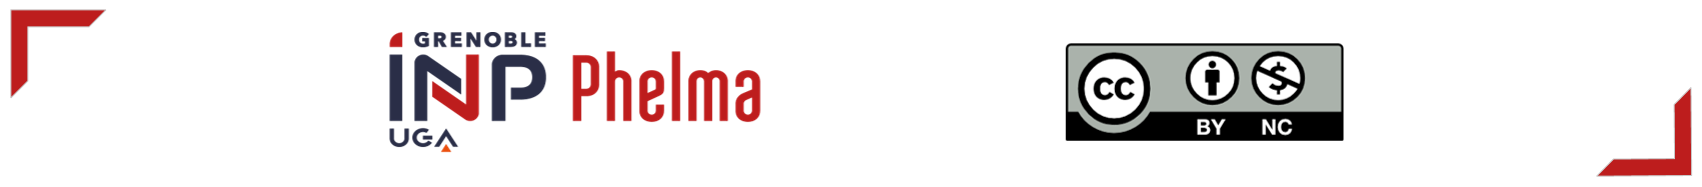</a>